In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import svm, naive_bayes, metrics, preprocessing

from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("/home/josefelipe/Documents/IA-Thais/prova/titanic/train.csv", encoding='UTF-8')

## Limpeza dos dados

O primeiro ponto a ser levado em conta será detectar dados faltantes no dataset de treino.

In [3]:
print('Dados nulos por colunas:\n', train_df.isnull().sum())

Dados nulos por colunas:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Há células defeituosas nas colunas _'Cabin'_ , _'Age'_ e _'Embarked'_. No caso da coluna _'Cabin'_ , o número de linhas com defeito é muito grande em relação ao total, tentar preencher pode ser ruim para o teste, no caso da coluna _'Age'_ os dados faltantes podem ser preenchidos pela média das idades por ser dado quantitativo, e na coluna _'Embarked'_ seria completado com a moda, já que é um dado qualitativo.

In [4]:
train_df.drop(['Cabin'], axis=1, inplace = True)

In [5]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace = True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)

In [6]:
print('Dados nulos por colunas:\n', train_df.isnull().sum())

Dados nulos por colunas:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Tratados os dados faltantes, é necessário remover também os dados que não agregam ao teste. Dados como nome, Id, Ticket, são únicas de cada passageiro, podendo ser descartadas sem causar prejuízo ao teste.

In [7]:
unuseble_data = ['Name', 'PassengerId', 'Ticket']
train_df.drop(unuseble_data, axis=1, inplace = True)

In [8]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
None


Agora o dataset de treino possui 8 colunas, todas preenchidas com valores não nulos e que seão levados em conta no teste.

## Matriz de correlação

Para produzir a matriz de correlação é necessário transformar valores qualitativos em quantitavos, tais como sexo e porto de embarque.

In [9]:
def sex_to_number(x):
    if x == 'male':
        return 1
    else:
        return 2
    
def embarked_to_number(x):
    if x == 'C':
        return 1
    elif x == 'Q':
        return 2    
    else:
        return 3

train_df['Sex'] = train_df['Sex'].apply(sex_to_number)
train_df['Embarked'] = train_df['Embarked'].apply(embarked_to_number)

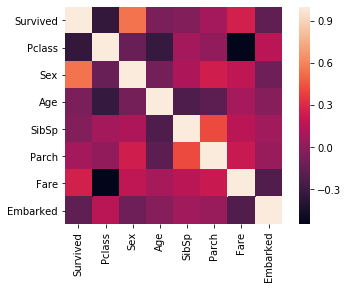

In [10]:
sns.heatmap(train_df.corr(method='pearson'), vmax=1, square=True)

Com o _plot_ da matriz de correalção foi possível notar a alta relação de classes com o resultados e de classes entre si. A classe com maior correlação com o resultado foi a do sexo dos passageiros, seguido de sua classe e taxa paga. As classes de taxa paga e classe têm alta correlação, deixando a entender que uma coisa leva a outra, então apenas uma delas será levada em conta na análise, algo parecido ocorre com as classes com respeito ao número de parentes ( _'SibSp'_  e _'Parch'_ ) porém nesse caso a classe _'SibSp'_ será descartada por possuir menor correlação om o resultado.

In [11]:
def sex_to_string(x):
    if x == 1:
        return 'male'
    else:
        return 'female'
    
def embarked_to_string(x):
    if x == 1:
        return 'C'
    elif x == 2:
        return 'Q'    
    else:
        return 'S'

train_df['Sex'] = train_df['Sex'].apply(sex_to_string)
train_df['Embarked'] = train_df['Embarked'].apply(embarked_to_string)

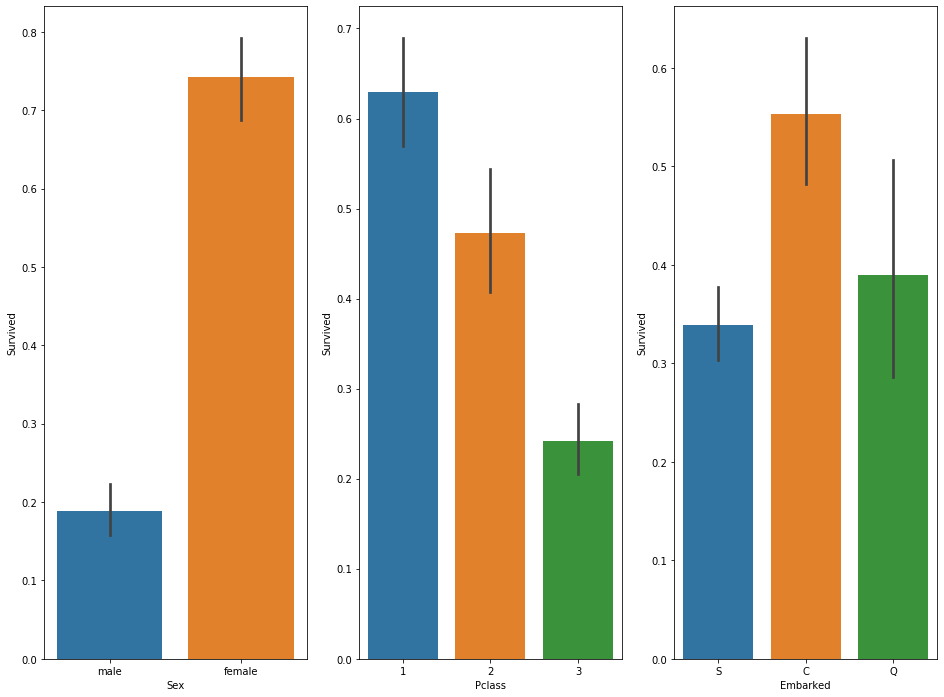

In [12]:
fig, saxis = plt.subplots(1, 3,figsize=(16,12))

sns.barplot(x = 'Sex', y = 'Survived', order=['male','female'], data=train_df, ax = saxis[0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=train_df, ax = saxis[1])
sns.barplot(x = 'Embarked', y = 'Survived', data=train_df, ax = saxis[2])

Como notado na matriz de correlação e nos gráficos acima, as informações que mais inluenciaram no resultado final foram o sexo do passageiro, a classe e o porto de embarque. A idade dos passageiros e a quantidade de parentes a bordo também influenciou, além da taxa paga, mas para fins de visualização não eram informações interessantes.

## Identificando Outliers

Nessa fase serão analisadas as classes que possuem valores contínuos para a identificação de outliers.

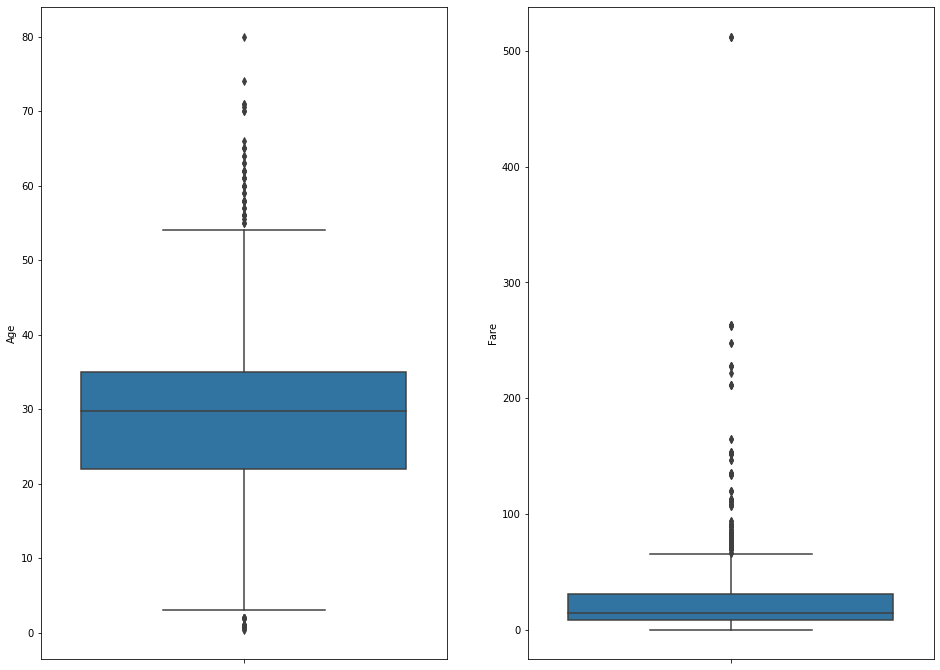

In [13]:
fig, saxis = plt.subplots(1, 2,figsize=(16,12))

sns.boxplot(y = 'Age', data=train_df, order=['male','female'], ax = saxis[0])
sns.boxplot(y = 'Fare', data=train_df, order=[1, 2, 3], ax = saxis[1])

Observando os dados é pssível perceber a presença de outliers nas colunas _'Fare'_ , e apesar de sua alta relação com o resultado final, esse tipo de informação com valores exorbitantes em relação à média pode atrapalhar o treino, dado que essa classe tem grande correlação com a classe _'Pclass'_ , a sua correlação com o resultado não será descartada. O gráfico da classe _'Age'_ possui alta variância porém com valores factíveis, e tendo alta correlação com o resultado final, é interessante que seja mantida no teste. 

## Balanceamento das classes

Nessa fase são levadas em conta as classes que ainda são relevantes para o treino. É checado o balanceamento das classes por meio de histogramas.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed3721a7b8>]],
      dtype=object)

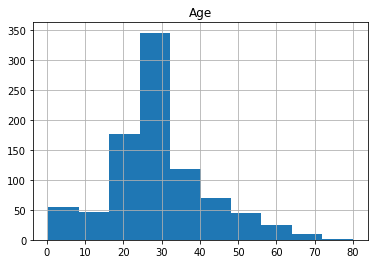

In [14]:
train_df.hist(column='Age')

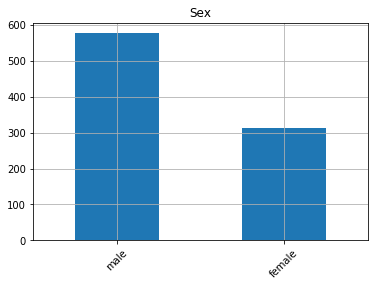

In [15]:
train_df['Sex'].value_counts().plot(title = 'Sex', kind = 'bar', grid = True, rot = 45)

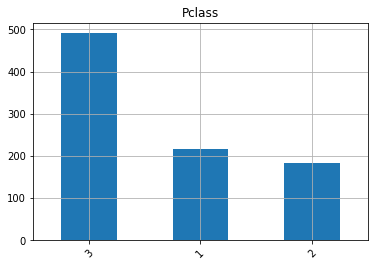

In [16]:
train_df['Pclass'].value_counts().plot(title = 'Pclass' ,kind = 'bar', grid = True, rot = 45)

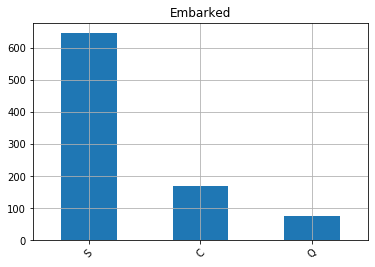

In [17]:
train_df['Embarked'].value_counts().plot(title = 'Embarked', kind = 'bar', grid = True, rot = 45)

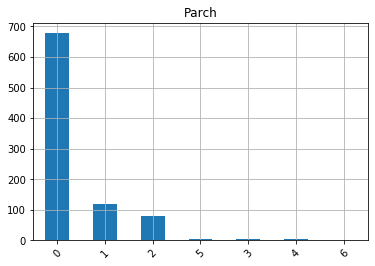

In [18]:
train_df['Parch'].value_counts().plot(title = 'Parch',kind = 'bar', grid = True, rot = 45)

Há uma constatação a se fazer quanto à analíse das classes, apesar de a grande maioria dos passageiros terem embarcado no porto S, foi desse porto o menor número de subreviventes. Assim como a classe de cada passageiro, a maioria fazia parte da classe 3 porém a classe 1 teve maior número de sobreviventes. Percebe-se também o fato de que mais de 60% da tripulação era do sexo masculino, porém o número maior de sobreviventes foi do sexo feminino.

Apesar do desbalanceamento da classe _'Parch'_ , é importante mantê-la no treino por sua alta correlação com o resultado.

## Treinamento e teste

### Dividir os dados aleatoriamente entre teste e treino

In [19]:
train_df['Sex'] = train_df['Sex'].apply(sex_to_number)
train_df['Embarked'] = train_df['Embarked'].apply(embarked_to_number)

In [20]:
train_data = ['Sex', 'Embarked', 'Pclass', 'Age', 'Parch']
train_target = ['Survived']

train_df.drop_duplicates(subset=train_data, keep=False, inplace=True)

train_df = pd.get_dummies(train_df)

X_train, X_test, y_train, y_test = train_test_split(train_df[train_data], train_df[train_target], test_size=0.2, random_state=0)

O dataset foi dividido em 80% para treino e 20% para teste.

### Aplicação dos algoritmos de classificação

Para a predição do resultado foram escolhidos os algoritmos Support Vector Machine com kernel linear e Naive Bayes Gaussiano.

### SVM

A escolha da SVM foi por seu caráter linear, sendo considerado o melhor algoritmo para a classificação entre duas classes, que é o caso.

In [21]:
SVM_classifier = svm.SVC(kernel='linear', C=10).fit(X_train, y_train)

y_predict_svm = SVM_classifier.predict(X_test)

print("accuracy:", round(SVM_classifier.score(X_test, y_test)*100, 2),'%')

cm_svm = metrics.confusion_matrix(y_test, y_predict_svm)
print("confusion matrix:\n", cm_svm)

print("f1 score:", round(metrics.f1_score(y_test, y_predict_svm), 2))
print("sensibility score:", round(metrics.precision_score(y_test, y_predict_svm), 2))
print("specificity score:", round(metrics.recall_score(y_test, y_predict_svm), 2))

accuracy: 84.38 %
confusion matrix:
 [[28  3]
 [ 7 26]]
f1 score: 0.84
sensibility score: 0.9
specificity score: 0.79


### Naive Bayes

A escolha do Naive Bayes foi por seu caráter probabilístico e dado que o número de parâmetros a serem levados em conta nesse problema é pequeno.

In [22]:
NB_classifier = naive_bayes.GaussianNB()
NB_classifier.fit(X_train, y_train)

y_predict_nb = NB_classifier.predict(X_test)

print("accuracy:", round(NB_classifier.score(X_test, y_test)*100,2),'%')

cm_nb = metrics.confusion_matrix(y_test, y_predict_nb)
print("confusion matrix:\n", cm_nb)

print("f1 score:", round(metrics.f1_score(y_test, y_predict_nb), 2))
print("sensibility score:", round(metrics.precision_score(y_test, y_predict_nb), 2))
print("specificity score:", round(metrics.recall_score(y_test, y_predict_nb), 2))

accuracy: 84.38 %
confusion matrix:
 [[28  3]
 [ 7 26]]
f1 score: 0.84
sensibility score: 0.9
specificity score: 0.79
